In [4]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [9]:
# Step 2: Load Dataset
df = pd.read_csv("../data/netflix_titles.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [10]:
# Step 3: Data Cleaning
# Drop unnecessary columns
df = df.drop(['show_id', 'cast', 'description', 'director'], axis=1)

In [11]:
# Drop duplicates
df.drop_duplicates(inplace=True)


In [12]:
# Handle missing values
df['rating'].fillna(df['rating'].mode()[0], inplace=True)
df['duration'].fillna("0 min", inplace=True)
df['listed_in'].fillna("Unknown", inplace=True)

/var/folders/0h/scqyrwfn4mj3fpkcf941nz9r0000gn/T/ipykernel_26018/2822017268.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(df['rating'].mode()[0], inplace=True)
/var/folders/0h/scqyrwfn4mj3fpkcf941nz9r0000gn/T/ipykernel_26018/2822017268.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [13]:
# Step 4: Feature Engineering
# Extract duration in minutes
def extract_duration(value):
    try:
        if 'min' in value:
            return int(value.split()[0])
        elif 'Season' in value:
            return int(value.split()[0]) * 60  # Approximation for series
        else:
            return 0
    except:
        return 0

df['duration_minutes'] = df['duration'].apply(extract_duration)

In [14]:
# Encode rating
le = LabelEncoder()
df['rating_encoded'] = le.fit_transform(df['rating'])

In [15]:
# Handle genre (listed_in)
df['genres'] = df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)

In [16]:
# Combine features
features = pd.concat([df[['release_year', 'duration_minutes', 'rating_encoded']], genre_dummies], axis=1)

In [17]:
# Step 5: Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(features)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invali

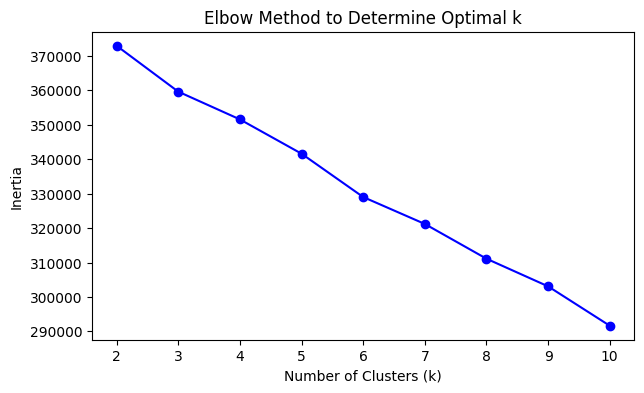

In [18]:
# Step 6: Find Optimal k (Elbow Method)
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [19]:
# Step 7: Apply K-Means Clustering
optimal_k = 5   # You can change based on elbow result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invali

In [20]:
# Step 8: Evaluate Clustering
silhouette_avg = silhouette_score(X, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Silhouette Score: 0.080


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

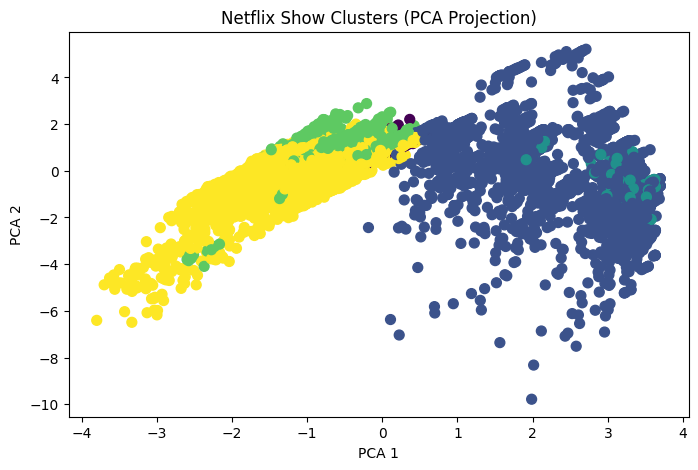

In [22]:
# Step 9: Visualize Clusters using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', s=50)
plt.title('Netflix Show Clusters (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [23]:
# Step 10: Analyze Clusters
print("Cluster Summary:\n")
cluster_summary = df.groupby('Cluster')[['release_year', 'duration_minutes']].mean()
print(cluster_summary)

Cluster Summary:

         release_year  duration_minutes
Cluster                                
0         2015.603499         67.326531
1         2016.671089        106.678112
2         2016.569536         75.894040
3         2015.277011         81.549425
4         2012.502459        105.465574


In [24]:
# Distribution by Genre per Cluster
cluster_genre = df.groupby('Cluster')['listed_in'].apply(lambda x: ', '.join(x)).reset_index()

/var/folders/0h/scqyrwfn4mj3fpkcf941nz9r0000gn/T/ipykernel_26018/2560063488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='Set2')


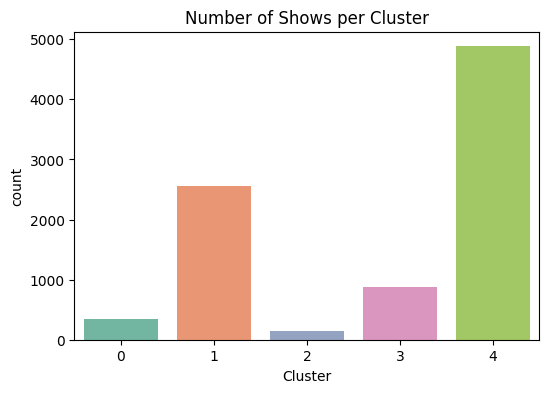

In [25]:
# Plot Cluster Counts
plt.figure(figsize=(6, 4))
sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title('Number of Shows per Cluster')
plt.show()

In [26]:
# Step 11: Save Results
df.to_csv('netflix_clustered.csv', index=False)
print("Clustered dataset saved as netflix_clustered.csv")


Clustered dataset saved as netflix_clustered.csv


In [27]:
# Step 12: Display Top Shows from Each Cluster
for i in range(optimal_k):
    print(f"\n--- Cluster {i} Sample Shows ---")
    print(df[df['Cluster'] == i][['title', 'type', 'rating', 'duration', 'listed_in']].head(5))


--- Cluster 0 Sample Shows ---
                            title   type rating duration        listed_in
278   Lokillo: Nothing's the Same  Movie  TV-MA   64 min  Stand-Up Comedy
359  The Original Kings of Comedy  Movie      R  111 min  Stand-Up Comedy
475                  The Stand-Up  Movie  TV-MA   93 min  Stand-Up Comedy
484  Lee Su-geun: The Sense Coach  Movie   TV-G   46 min  Stand-Up Comedy
766       Alan Saldaña: Locked Up  Movie  TV-MA   49 min  Stand-Up Comedy

--- Cluster 1 Sample Shows ---
                   title     type rating   duration  \
1          Blood & Water  TV Show  TV-MA  2 Seasons   
2              Ganglands  TV Show  TV-MA   1 Season   
3  Jailbirds New Orleans  TV Show  TV-MA   1 Season   
4           Kota Factory  TV Show  TV-MA  2 Seasons   
5          Midnight Mass  TV Show  TV-MA   1 Season   

                                           listed_in  
1    International TV Shows, TV Dramas, TV Mysteries  
2  Crime TV Shows, International TV Shows, TV Act..